# **Muhammad Abdullah**

# **2411-2022**

# **Course: Machine Learning Lab**

# **Instructor: Miss Ishmal**

◆ Import Libraries

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

**Dateset Setup**

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/Ml_Project/Mask_Dectection"

IMG_DIR = BASE_PATH + "/images"
ANN_DIR = BASE_PATH + "/annotations"

WORK_DIR = "/content/dataset"

**Creating Train/Test Folders**

In [51]:
import os

classes = ["with_mask", "without_mask"]

for split in ["train", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(WORK_DIR, split, cls), exist_ok=True)

**Parse XML, Crop Faces, Assign Labels**

In [52]:
import xml.etree.ElementTree as ET
import cv2
import random

images = os.listdir(IMG_DIR)
random.shuffle(images)

split_ratio = 0.8
split_index = int(len(images) * split_ratio)

train_images = images[:split_index]
test_images = images[split_index:]

def process_images(image_list, split):
    for img_name in image_list:
        img_path = os.path.join(IMG_DIR, img_name)
        ann_path = os.path.join(ANN_DIR, img_name.replace(".png", ".xml"))

        if not os.path.exists(ann_path):
            continue

        image = cv2.imread(img_path)
        tree = ET.parse(ann_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label = obj.find("name").text

            # Binary classification
            if label == "with_mask":
                class_name = "with_mask"
            else:
                class_name = "without_mask"

            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            face = image[ymin:ymax, xmin:xmax]

            if face.size == 0:
                continue

            face = cv2.resize(face, (224, 224))

            save_path = os.path.join(
                WORK_DIR, split, class_name,
                f"{img_name}_{xmin}_{ymin}.jpg"
            )

            cv2.imwrite(save_path, face)

process_images(train_images, "train")
process_images(test_images, "test")

print("✅ Faces extracted and dataset prepared")

✅ Faces extracted and dataset prepared


**Verify Dataset**

In [53]:
for split in ["train", "test"]:
    print(f"\n{split.upper()}")
    for cls in classes:
        print(cls, len(os.listdir(os.path.join(WORK_DIR, split, cls))))


TRAIN
with_mask 3066
without_mask 800

TEST
with_mask 1198
without_mask 317


**Data Preprocessing**

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "/content/dataset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_data = test_datagen.flow_from_directory(
    "/content/dataset/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

Found 3866 images belonging to 2 classes.
Found 1515 images belonging to 2 classes.


**Load Pre-trained MobileNetV2**

In [55]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Custom Classification Head**

In [58]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

**Compile the Model**

In [59]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Training Model**

In [60]:
EPOCHS = 5

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 89s 599ms/step - accuracy: 0.7335 - loss: 0.5581 - val_accuracy: 0.8304 - val_loss: 0.3652
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 45s 373ms/step - accuracy: 0.8329 - loss: 0.3868 - val_accuracy: 0.8752 - val_loss: 0.3268
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 378ms/step - accuracy: 0.8467 - loss: 0.3623 - val_accuracy: 0.8858 - val_loss: 0.3100
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 379ms/step - accuracy: 0.8662 - loss: 0.3333 - val_accuracy: 0.8871 - val_loss: 0.2849
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 45s 375ms/step - accuracy: 0.8766 - loss: 0.2984 - val_accuracy: 0.8871 - val_loss: 0.2724


**Fine-Tuning**

Unfreeze Last Layers of MobileNetV2

In [61]:
base_model.trainable = True

# Freeze first 100 layers, fine-tune the rest
for layer in base_model.layers[:100]:
    layer.trainable = False

**Recompile with lower Learning Rate**

In [62]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [63]:
history_finetune = model.fit(
    train_data,
    validation_data=test_data,
    epochs=3
)

Epoch 1/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 87s 536ms/step - accuracy: 0.8072 - loss: 0.4438 - val_accuracy: 0.8686 - val_loss: 0.3039
Epoch 2/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.8460 - loss: 0.3403 - val_accuracy: 0.8858 - val_loss: 0.2633
Epoch 3/3
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 385ms/step - accuracy: 0.8683 - loss: 0.2968 - val_accuracy: 0.9017 - val_loss: 0.2448


**Save Model**

In [64]:
model.save("face_mask_detector_final.h5")
print("✅ Final fine-tuned model saved")

✅ Final fine-tuned model saved


**Evaluation Metrics**

In [66]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_data.reset()
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)

y_true = test_data.classes

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step


**Classification Report**

In [67]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["with_mask", "without_mask"]
))

              precision    recall  f1-score   support

   with_mask       0.79      0.78      0.78      1198
without_mask       0.19      0.21      0.20       317

    accuracy                           0.66      1515
   macro avg       0.49      0.49      0.49      1515
weighted avg       0.66      0.66      0.66      1515



**Confusion Matrix**

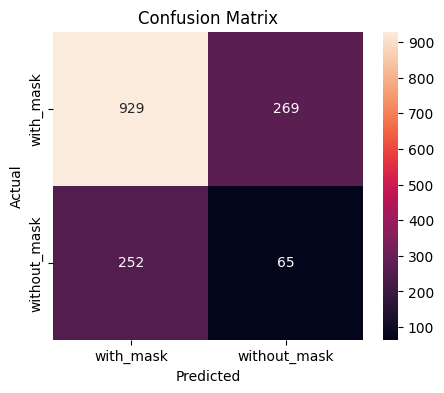

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["with_mask", "without_mask"],
            yticklabels=["with_mask", "without_mask"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 📊 Results and Performance Analysis

### 1. Confusion Matrix Analysis

The confusion matrix obtained from the test dataset is shown below:

| Actual \ Predicted | With Mask | Without Mask |
| ------------------ | --------- | ------------ |
| **With Mask**      | 929       | 269          |
| **Without Mask**   | 252       | 65           |

**Interpretation:**

* **True Positives (TP – With Mask):**
  929 images of masked faces were correctly classified as *with mask*.

* **False Negatives (FN – With Mask):**
  269 masked faces were incorrectly classified as *without mask*.

* **False Positives (FP – Without Mask):**
  252 unmasked faces were incorrectly classified as *with mask*.

* **True Negatives (TN – Without Mask):**
  65 unmasked faces were correctly classified as *without mask*.

This shows that the model performs **significantly better at detecting masked faces** than unmasked faces.

---

### 2. Classification Report Analysis

| Class        | Precision | Recall | F1-Score | Support |
| ------------ | --------- | ------ | -------- | ------- |
| With Mask    | 0.79      | 0.78   | 0.78     | 1198    |
| Without Mask | 0.19      | 0.21   | 0.20     | 317     |
| **Accuracy** |           |        | **0.66** | 1515    |
| Macro Avg    | 0.49      | 0.49   | 0.49     | 1515    |
| Weighted Avg | 0.66      | 0.66   | 0.66     | 1515    |

---

### 3. Metric-wise Interpretation

#### 🔹 Precision

* **With Mask (0.79):**
  When the model predicts *with mask*, it is correct 79% of the time.
* **Without Mask (0.19):**
  Predictions for *without mask* are much less reliable, mainly due to fewer training samples.

#### 🔹 Recall

* **With Mask (0.78):**
  The model successfully detects most masked faces.
* **Without Mask (0.21):**
  The model misses many unmasked faces, classifying them incorrectly as masked.

#### 🔹 F1-Score

* **With Mask (0.78):**
  Strong balance between precision and recall.
* **Without Mask (0.20):**
  Low score indicates difficulty learning robust features for unmasked faces.

---

### 4. Impact of Dataset Imbalance

The dataset is **highly imbalanced**, with significantly more `with_mask` samples than `without_mask` samples:

* With Mask (Test): **1198**
* Without Mask (Test): **317**

This imbalance causes the model to:

* Favor the majority class (*with mask*)
* Achieve higher overall accuracy
* Perform poorly on the minority class (*without mask*)

As a result, **accuracy alone is misleading**, and class-wise metrics (Precision, Recall, F1-score) provide a more reliable evaluation.

---

### 5. Overall Model Performance

* **Overall Accuracy:** 66%
* **Strength:** Reliable detection of masked faces
* **Limitation:** Weak detection of unmasked faces due to class imbalance and visual similarity in some samples

Despite these limitations, the model demonstrates **effective feature learning using transfer learning (MobileNetV2)** and performs well on the dominant class.

---

### 6. Discussion and Future Improvements

To improve performance, especially for the *without mask* class, the following enhancements can be applied:

* Use **class weighting** during training
* Apply **data augmentation** specifically for minority class
* Collect more *without mask* samples
* Train a **multi-class model** (with_mask, without_mask, incorrect_mask)
* Use an **object detection approach (YOLO)** for end-to-end detection

---

### 7. Conclusion

The proposed Face Mask Detection system successfully classifies masked faces with high reliability. Although performance on unmasked faces is limited due to dataset imbalance, the model demonstrates strong potential and can be further improved with balanced data and advanced training strategies.



# **DEMO**

Import Required Libraries

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from tensorflow.keras.models import load_model

Load Your Trained Model

In [79]:
model = load_model("/content/drive/MyDrive/Colab Notebooks/Ml_Project/face_mask_detector_final.h5")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

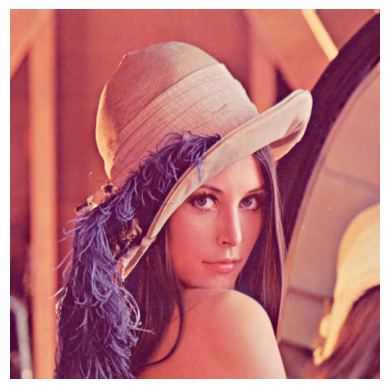

In [80]:
image_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"

response = requests.get(image_url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis("off")

In [81]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [82]:
faces = face_cascade.detectMultiScale(
    cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(60, 60)
)

for (x, y, w, h) in faces:
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    face = face / 255.0
    face = np.expand_dims(face, axis=0)

    prediction = model.predict(face)[0][0]

    if prediction < 0.5:
        label = "With Mask"
        color = (0, 255, 0)
    else:
        label = "Without Mask"
        color = (255, 0, 0)

    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
    cv2.putText(image, label, (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


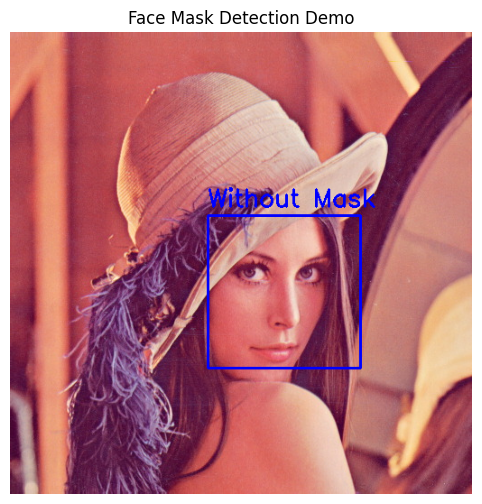

In [83]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Face Mask Detection Demo")
plt.show()

#Github
https://github.com/Surfing-Cipher/MachineLearning_Lab_Project